In [29]:
import torch
from src.Datasets import load
from torch.utils.data import DataLoader
from src.model import Conv_Net_FC_Dropout
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


In [31]:
models = []
for i in range(10):
    model = Conv_Net_FC_Dropout()
    model.load_state_dict(torch.load(f"models/ensemble_10ep/run_{i}.pth"))
    model.to('cuda')
    model.eval()
    models.append(model)

In [32]:
mnist = load('MNIST')(train = False)
mnist_loader = DataLoader(mnist, batch_size=128, shuffle=False)

cifar = load('CIFAR10')(train = False)
cifar_loader = DataLoader(cifar, batch_size=128, shuffle=False)

Files already downloaded and verified


In [33]:
mnist_uncertainty = []
with torch.no_grad():
    for x,_ in tqdm(mnist_loader):
        x = x.to('cuda')
        out = []
        for model in models:
            out.append(model(x).cpu())
        out = torch.stack(out)
        mnist_uncertainty.append(out.std(dim=0).mean(dim=-1))
mnist_uncertainty = torch.cat(mnist_uncertainty)

100%|██████████| 79/79 [00:00<00:00, 88.51it/s]


In [34]:
cifar_uncertainty = []
with torch.no_grad():
    for x,_ in tqdm(cifar_loader):
        x = x.to('cuda')
        out = []
        for model in models:
            out.append(model(x).cpu())
        out = torch.stack(out)
        cifar_uncertainty.append(out.std(dim=0).mean(dim=-1))
cifar_uncertainty = torch.cat(cifar_uncertainty)

100%|██████████| 79/79 [00:01<00:00, 60.57it/s]


In [35]:
print('CIFAR10 mean uncertainty:', cifar_uncertainty.mean().item())
print('MNIST mean uncertainty:', mnist_uncertainty.mean().item())

CIFAR10 mean uncertainty: 0.06569962948560715
MNIST mean uncertainty: 0.0030258879996836185


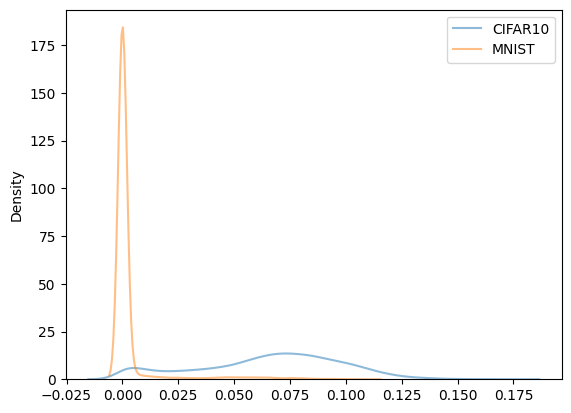

In [36]:
sns.kdeplot(cifar_uncertainty,alpha=0.5, label='CIFAR10')
sns.kdeplot(mnist_uncertainty,alpha=0.5, label='MNIST')
plt.legend()
plt.show()

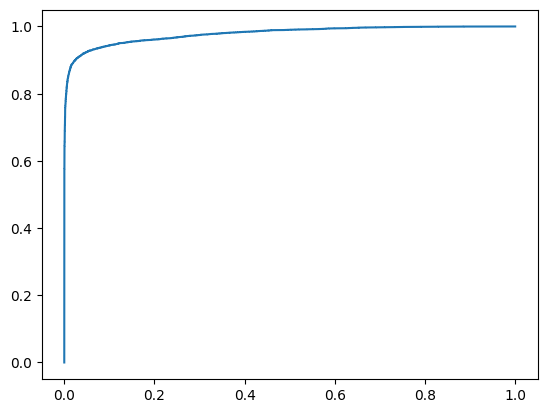

In [37]:
fpr,tpr, thresholds = roc_curve(np.concatenate((np.zeros_like(cifar_uncertainty),np.ones_like(mnist_uncertainty))),np.concatenate(( -cifar_uncertainty, -mnist_uncertainty)))
plt.plot(fpr, tpr)


In [38]:
print('AUC:', auc(fpr,tpr))

AUC: 0.9782327399999999
